In [1]:
import cPickle as pickle
from download_songs import BinacaYear, Song
import glob
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize

In [2]:
def analyse(by):
    word_list = collections.defaultdict(float)
    
    for song in by.songs:
        tokens = word_tokenize(song.lyrics)
        for word in tokens:
            word_list[word] += 1
    
    total_words = sum(word_list.values())
    word_list = {k: v/total_words for k, v in word_list.iteritems()}
    return word_list


In [3]:
binaca_year = {}
for i in glob.glob("./songs/*.p"):
    binaca_year[int(i[-6:-2])] = pickle.load(open(i, "rb"))


In [4]:
binaca_dict = {}
for year in binaca_year.keys():
    binaca_dict[year] = analyse(binaca_year[year])


In [5]:
vocab = set()
for keys in binaca_dict.values():
    for i in keys.keys():
        vocab.add(i)
vocab = list(vocab)

In [6]:
def combine_dict(year_range):
    d = collections.defaultdict(float)
    for year in year_range:
        for k, v in binaca_dict[year].iteritems():
            d[k] += v
    return d

def get_top_n_words(n, year_range):
    d = combine_dict(year_range)
    m = [[v, k] for k, v in d.iteritems()]
    m.sort(reverse=True)
    return set(map(lambda i: i[1], m[n]))

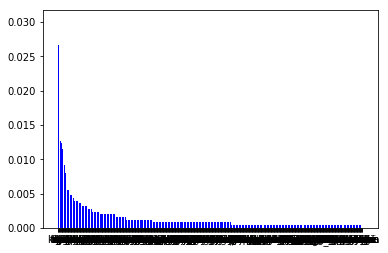

In [7]:
d = binaca_dict[1954]
m = [(v, k) for k, v in d.iteritems()]
m.sort(reverse=True)
x = range(len(m))
plt.bar(x, map(lambda i: i[0], m), 1/1.5, color="blue")
plt.xticks(x, map(lambda i: i[1], m))
plt.show()

In [8]:
#see how words changed over time

s_v = slice(100, 200)
seta = get_top_n_words(s_v, range(1955, 1965))
setb = get_top_n_words(s_v, range(1973, 1983))

for i in seta:
    if i not in setb:
        print i, ',',
print
print '-' * 81

for i in setb:
    if i not in seta:
        print i, ',',
print

bhee , mila , maine , jara , koyi , leke , jaago , aaye , bat , magar , sang , chaand , bahar , ban , gagan , haay , diya , naam , allah , nain , are , najar , sun , ichak , kyaa , phul , ruk , kee , kaun , bol , haa , chand , rang , diye , zindagi , bhayo , toh , tumhe , kahe , mora , more , manzil , yaha , yahi , chup , gayo , ram , haye , kyo , hamara , karu , sab , is , in , kuch , hame , sar , khabar , hindustani , jaha , barse , kah , jiya , kiya , jaise , bade , sa , tha ,
---------------------------------------------------------------------------------
raja , mehbuba , chori , hath , mile , ga , nahin , jay , hay , jaa , jayenge , kisi , maar , mujhko , apne , du , bas , jaana , sanam , milan , ru , aate , jaate , bole , dekha , jate , jata , jaan , chor , bhai , bhar , dono , prem , tujhe , kahi , jana , chaahiye , jhum , piya , gori , he , apna , ma , aao , aai , aap , kahaan , zara , badal , chale , raha , rahe , aha , karo , saath , mil , hoo , shaadi , nam , jivan , mat , 

In [9]:
import sys
sys.path.insert(0, "/home/harshil/Apps/faiss/")
import faiss

Failed to load GPU Faiss: No module named swigfaiss_gpu
Faiss falling back to CPU-only.


In [10]:
year_data = np.zeros([len(binaca_dict.keys()), len(vocab)]).astype('float32')

word_key = dict()
for i, val in enumerate(vocab):
    word_key[val] = i

for year in binaca_year.keys():
    for k, v in binaca_dict[year].iteritems():
        year_data[year-min(binaca_dict.keys())][word_key[k]] = float(v)

year_data = np.ascontiguousarray(year_data.T)

In [11]:
k = 10
index = faiss.IndexFlatL2(year_data.shape[1])
index.add(year_data)
D, I = index.search(year_data, k+1)
pickle.dump(I, open('indexes.p', 'wb+'))

In [13]:
I = pickle.load(open('indexes.p', 'rb+'))

In [14]:
import networkx as nx
G=nx.Graph()
G.add_nodes_from(range(len(vocab)))

for i in range(len(vocab)):
    for j in I[i]:
        if j == i:
            continue
        G.add_edge(i, j)

In [15]:
def print_i(j):
    print vocab[j]
    for i in G.neighbors(j):
        print vocab[i],

print_i(1732)

hindustani
desh dir rona radhika bhigi abhi dadi-amma madhuban saval nasha


In [16]:
from sklearn.cluster import SpectralClustering
from sklearn import metrics

In [17]:
vocab.index('hindustani')

1732

In [ ]:
adj_mat = nx.to_numpy_matrix(G)
sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(adj_mat)

print('spectral clustering')
print(sc.labels_)